## Table of Content

- [1.0 - Introduction](#1.0)
- [2.0 - Dataset Collection](#2.0)
- [3.0 - Packages](#3.0)
- [4.0 - Data Pre-Processing](#4.0)
- [5.0 - Data Exploration](#5.0)
- [6.0 - Collect/Process Data for training](#6.0)

<a name='1.0'></a>
#### 1.0 Introduction

The objective of this project is to create a content-based fashion recommender system by utilizing visual representations for ranking and retrieval. When shopping for clothing online, the appearance of a garment piece is often an important factor in the decision making process.

With the availability of visual data online, visual search has become increasingly important to look for information that may be difficult to communicate through text. 

This project consists of three stages: data preparation, model training, and serving:
* The <b>data preparation</b> stage prepares the data that I use for training
* The <b>model training</b> stage classify images into categories and represents them with embeddings, in which images that are visually similar will be placed within closer distance in the embedding space
* Finally, in the <b>serving stage</b>, the vector representations of the images obtained from the model training will be indexed using a Nearest-Neighbor Algorithm for ranking and retrieval.

Take a look at the following flowchart for this project:
<figure>
    <center><img src="./images-from-train/eda-photos/fashion-recommender-flowchart.png" style="width:600px;height:300px"></center>
</figure>

<a name='2.0'></a>
#### 2.0 Dataset collection

 For this project, I utilized the public dataset for the paper <b>Bootstrapping Complete The Look at Pinterest</b>. Links to the datasets are available at this repo's readme.MD

The dataset consists of over 100,000 polyvore-style images (fashion boards) with white background and bounding boxes as the ground-truth label for fashion categories, with over 400,000 fashion objects identified in these images. Let's take a look at an example:

<figure>
    <center><img src="./images-from-train/eda-photos/cropped-image.png" style="width:400px; height:390px"></center>
</figure>

For the purpose of this project, I cropped each identified objects into individual images, and used 45,000 for training, 2,500 for validation, and 2,500 for testing.

In [1]:
!git clone https://github.com/eileenforwhat/complete-the-look-dataset.git

Cloning into 'complete-the-look-dataset'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 31 (delta 0), reused 2 (delta 0), pack-reused 28
Receiving objects: 100% (31/31), 64.08 MiB | 8.16 MiB/s, done.
Resolving deltas: 100% (4/4), done.


<a name='3.0'></a>
#### 3.0 Packages

In [1]:
import requests
import os
import random
import warnings
import csv

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)

<a name='4.0'></a>
#### 4.0 Data Pre-Processing

In [2]:
train_tf = pd.read_csv('../complete-the-look-dataset/datasets/raw_train.tsv', sep='\t', header=0)

In [3]:
train_tf.head(5)

image_signature bounding_x  bounding_y  bounding_width  bounding_height label
04fcde5521c0a404a4552329e5200673 0.144127 0.829421 0.321174 0.158302                                              Shoes                           
                                 0.705800 0.016559 0.274491 0.387417                                   Scarves & Shawls                           
                                 0.000789 0.000000 0.411467 0.477644                                    Coats & Jackets                           
                                 0.657567 0.562498 0.342433 0.437502                                           Handbags                           
04fd71ac51937e85fe1bfbda62d8ef45 0.738062 0.025290 0.196267 0.294209                                           Handbags

In [4]:
# Read the TSV file as lines
with open('../complete-the-look-dataset/datasets/raw_train.tsv', 'r') as file:
    lines = file.readlines()

# Extract column names (first line)
raw_column_names = lines[0].split(' ')

# Remove any empty strings from the list
column_names = [name for name in raw_column_names if name]

# Remove any empty strings from the list and strip '\n' from the 'label' column name
column_names = [name.strip() for name in raw_column_names if name]

column_names

['image_signature',
 'bounding_x',
 'bounding_y',
 'bounding_width',
 'bounding_height',
 'label']

In [5]:
# Remove leading and trailing white spaces from column names
train_tf.columns = train_tf.columns.str.strip()

In [6]:
data = [line.split('\t') for line in lines[1:]]
train_tf = pd.DataFrame(data, columns=column_names)

# Replace '\n' in the 'label' column with an empty string
train_tf['label'] = train_tf['label'].str.replace('\n', '')

In [7]:
train_tf.head()

,image_signature,bounding_x,bounding_y,bounding_width,bounding_height,label
0,04fcde5521c0a404a4552329e5200673,0.14412735,0.8294209,0.32117385,0.15830207,Shoes
1,04fcde5521c0a404a4552329e5200673,0.70579976,0.016558629,0.27449077,0.38741693,Scarves & Shawls
2,04fcde5521c0a404a4552329e5200673,7.892251E-4,0.0,0.41146725,0.47764385,Coats & Jackets
3,04fcde5521c0a404a4552329e5200673,0.6575671,0.56249845,0.34243292,0.43750155,Handbags
4,04fd71ac51937e85fe1bfbda62d8ef45,0.73806214,0.025290241,0.19626653,0.2942092,Handbags


In [8]:
# Use 50000 rows from the dataset
sample_size = 50000

sampled_train_tf = train_tf.sample(n=sample_size, random_state=42)
sampled_train_tf.reset_index(drop=True, inplace=True)

<a name='5.0'></a>
#### 5.0 Data Exploration

In [27]:
label_counts = sampled_train_tf['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']
label_counts

,label,count
0,Shoes,10499
1,Handbags,9706
2,Shirts & Tops,6322
3,Pants,5741
4,Coats & Jackets,4677
5,Dresses,3116
6,Jewelry,2713
7,Hats,2011
8,Skirts,1635
9,Shorts,1052


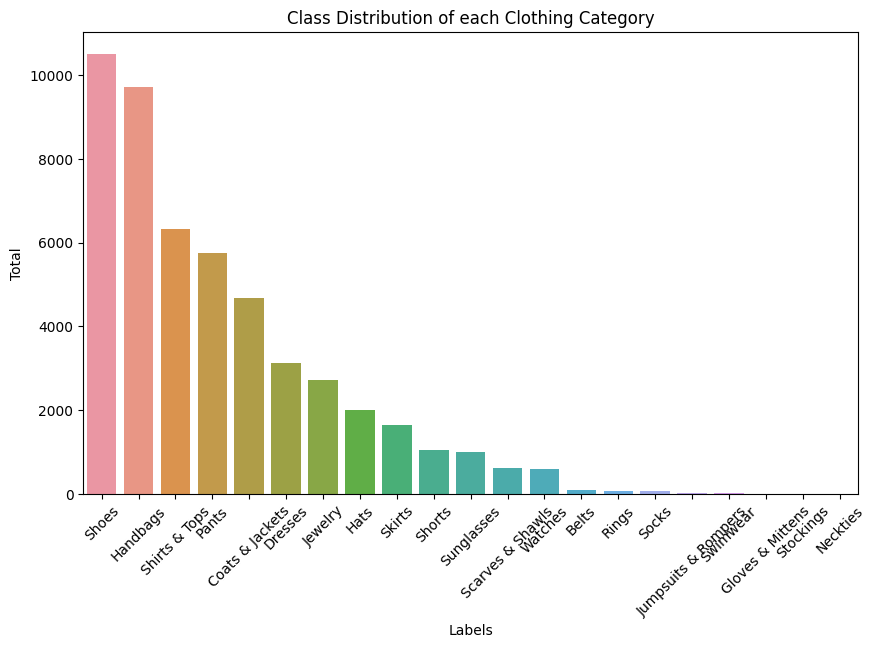

In [32]:
# Create a bar chart
plt.figure(figsize=(10, 6))  # Set the figure size
sns.barplot(data=label_counts, x='label', y ='count')
plt.xlabel('Labels')
plt.ylabel('Total')
plt.title('Class Distribution of each Clothing Category')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [9]:
# Define the sizes for train, validation, and test sets
train_size = 0.9  # 90% for training
validation_size = 0.05  # 5% for validation
test_size = 0.05  # 5% for testing

# Perform the split
train_df, temp_df = train_test_split(sampled_train_tf, test_size=1 - train_size, random_state=42)
validation_df, test_df = train_test_split(temp_df, test_size=test_size / (test_size + validation_size), random_state=42)

# Verify the sizes of the splits

len(train_df), len(validation_df), len(test_df)


(45000, 2500, 2500)

In [10]:
def convert_to_url(signature):
    prefix = 'http://i.pinimg.com/400x/%s/%s/%s/%s.jpg'
    return prefix % (signature[0:2], signature[2:4], signature[4:6], signature)

In [12]:
def visualize(image_signature, df, ax):
    # Retrieve the URL based on the image_signature
    url = convert_to_url(image_signature)
    
    # Retrieve all rows with the same image_signature
    rows = df[df['image_signature'] == image_signature]
    
    # Load the image from the URL
    image = Image.open(requests.get(url, stream=True).raw)
    draw = ImageDraw.Draw(image)
    
    # Loop through each row and draw bounding boxes
    for _, row in rows.iterrows():
        x = float(row['bounding_x'])
        y = float(row['bounding_y'])
        w = float(row['bounding_width'])
        h = float(row['bounding_height'])
        
        x1 = int(x * image.width)
        y1 = int(y * image.height)
        x2 = int((x + w) * image.width)
        y2 = int((y + h) * image.height)
        draw.rectangle((x1, y1, x2, y2), outline=(255, 0, 0), width=2)
    
    ax.imshow(image)
    ax.axis('off')

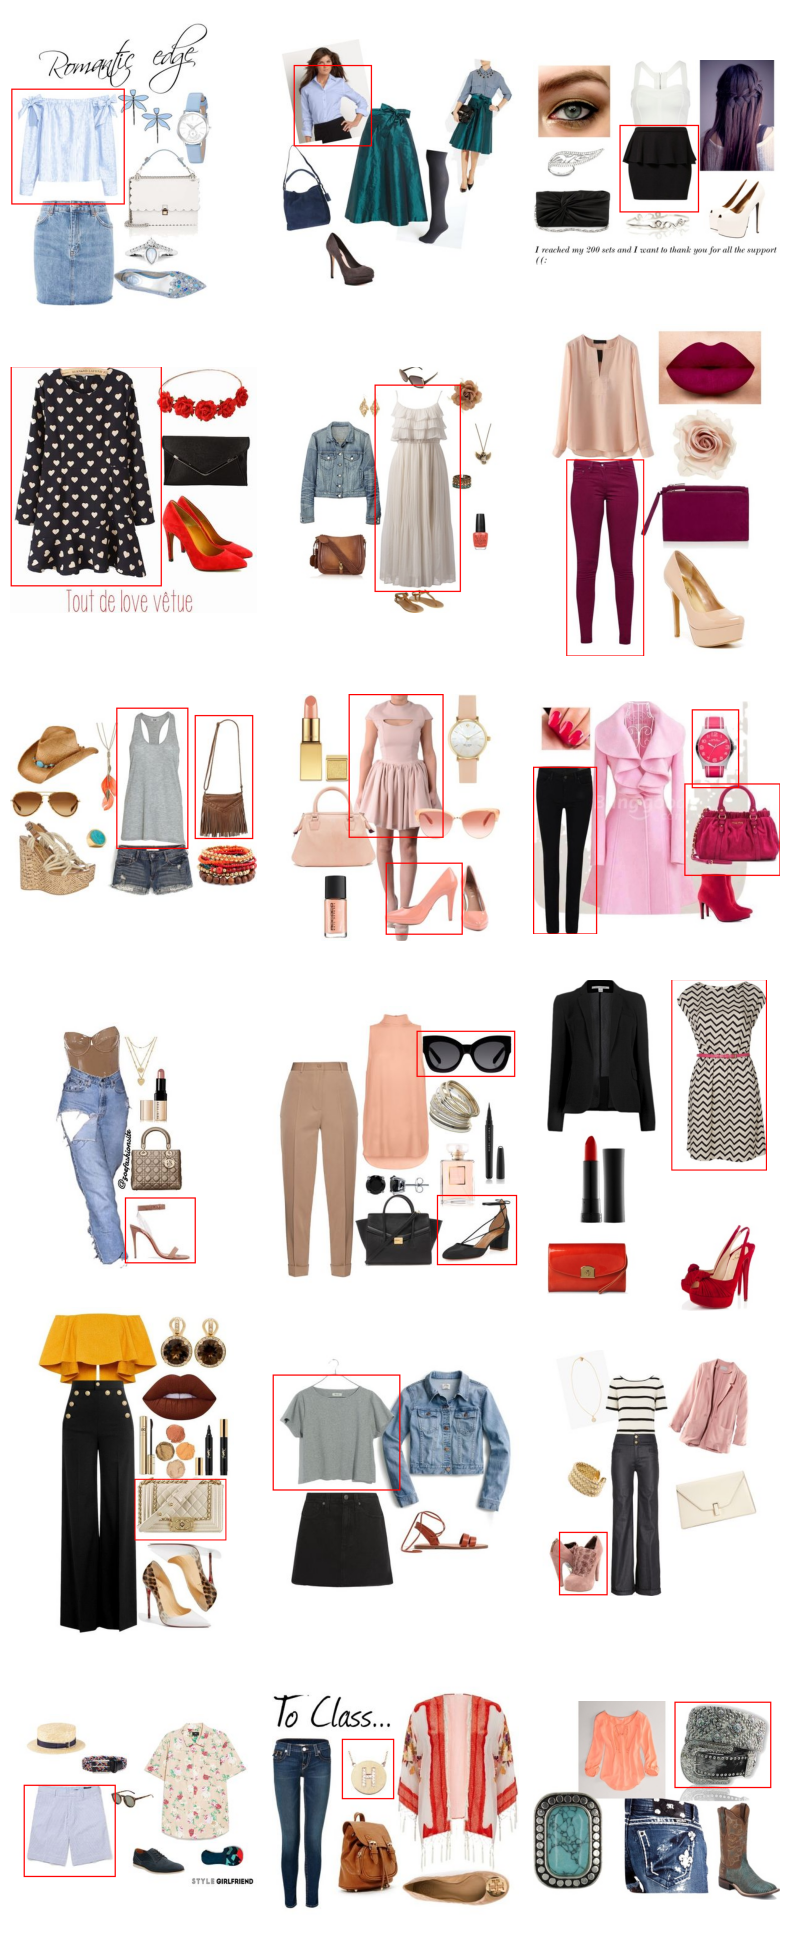

In [17]:
# Let's visualize some fashion boards with their respective bounding boxes
fig, axs = plt.subplots(6, 3, figsize=(8, 20))

for i in range(6):
    for j in range(3):
        # Get a random image_signature from the DataFrame
        random_signature = random.choice(train_df['image_signature'].unique())
        # Visualize the randomly selected image_signature in the current subplot
        visualize(random_signature, train_df, axs[i, j])

plt.tight_layout()
plt.show()

<a name='6.0'></a>
#### 6.0 Collect/Process Data for Training

In [37]:
# Create a directory to save the cropped item images
output_directory = 'train_dataset'
os.makedirs(output_directory, exist_ok=True)

In [ ]:
for sig in train_df['image_signature']:
    # Retrieve the URL for the image
    url = convert_to_url(sig)
    
    # Load the image
    image = Image.open(requests.get(url, stream=True).raw)
    
    # Filter rows that correspond to the current image_signature
    items = train_df[train_df['image_signature'] == sig]
    
    # Iterate through each detected item in the image
    for i, item in items.iterrows():
        x = float(item['bounding_x'])
        y = float(item['bounding_y'])
        w = float(item['bounding_width'])
        h = float(item['bounding_height'])

        x1 = int(x * image.width)
        y1 = int(y * image.height)
        x2 = int((x + w) * image.width)
        y2 = int((y + h) * image.height)
        
        # Crop the item from the image
        cropped_item = image.crop((x1, y1, x2, y2))
        
        # Save the cropped item with a unique filename
        item_label = item['label'].replace(' ', '_')  # Replace spaces with underscores
        filename = f"{sig}_{item_label}_{i}.jpg"
        cropped_item.save(os.path.join(output_directory, filename))


In [49]:
# Create a directory to save the cropped item images
output_directory_2 = 'train_dataset_2'
os.makedirs(output_directory_2, exist_ok=True)

In [50]:
for sig in train_df['image_signature']:
    try:
        # Retrieve the URL for the image
        url = convert_to_url(sig)

        # Load the image
        image = Image.open(requests.get(url, stream=True).raw)

        # Filter rows that correspond to the current image_signature
        items = train_df[train_df['image_signature'] == sig]

        # Iterate through each detected item in the image
        for i, item in items.iterrows():
            x = float(item['bounding_x'])
            y = float(item['bounding_y'])
            w = float(item['bounding_width'])
            h = float(item['bounding_height'])

            x1 = int(x * image.width)
            y1 = int(y * image.height)
            x2 = int((x + w) * image.width)
            y2 = int((y + h) * image.height)

            # Crop the item from the image
            cropped_item = image.crop((x1, y1, x2, y2))

            # Save the cropped item with a unique filename
            item_label = item['label'].replace(' ', '_')  # Replace spaces with underscores
            filename = f"{sig}_{item_label}_{i}.jpg"
            cropped_item.save(os.path.join(output_directory_2, filename))

    except Exception as e:
        print(f"Error processing image {sig}: {str(e)}")

Error processing image da5e553cbacb0382eb23ebed119916e4: cannot identify image file <_io.BytesIO object at 0x2b454fdb0>
Error processing image da5e553cbacb0382eb23ebed119916e4: cannot identify image file <_io.BytesIO object at 0x2b4526270>


In [51]:
# Create a directory to save the cropped item images
validation_directory = 'validation_dataset'
os.makedirs(validation_directory, exist_ok=True)

In [52]:
for sig in validation_df['image_signature']:
    try:
        # Retrieve the URL for the image
        url = convert_to_url(sig)

        # Load the image
        image = Image.open(requests.get(url, stream=True).raw)

        # Filter rows that correspond to the current image_signature
        items = validation_df[validation_df['image_signature'] == sig]

        # Iterate through each detected item in the image
        for i, item in items.iterrows():
            x = float(item['bounding_x'])
            y = float(item['bounding_y'])
            w = float(item['bounding_width'])
            h = float(item['bounding_height'])

            x1 = int(x * image.width)
            y1 = int(y * image.height)
            x2 = int((x + w) * image.width)
            y2 = int((y + h) * image.height)

            # Crop the item from the image
            cropped_item = image.crop((x1, y1, x2, y2))

            # Save the cropped item with a unique filename
            item_label = item['label'].replace(' ', '_')  # Replace spaces with underscores
            filename = f"{sig}_{item_label}_{i}.jpg"
            cropped_item.save(os.path.join(validation_directory, filename))

    except Exception as e:
        print(f"Error processing image {sig}: {str(e)}")

In [53]:
# Create a directory to save the cropped item images
test_directory = 'test_dataset'
os.makedirs(test_directory, exist_ok=True)

In [54]:
for sig in test_df['image_signature']:
    try:
        # Retrieve the URL for the image
        url = convert_to_url(sig)

        # Load the image
        image = Image.open(requests.get(url, stream=True).raw)

        # Filter rows that correspond to the current image_signature
        items = test_df[test_df['image_signature'] == sig]

        # Iterate through each detected item in the image
        for i, item in items.iterrows():
            x = float(item['bounding_x'])
            y = float(item['bounding_y'])
            w = float(item['bounding_width'])
            h = float(item['bounding_height'])

            x1 = int(x * image.width)
            y1 = int(y * image.height)
            x2 = int((x + w) * image.width)
            y2 = int((y + h) * image.height)

            # Crop the item from the image
            cropped_item = image.crop((x1, y1, x2, y2))

            # Save the cropped item with a unique filename
            item_label = item['label'].replace(' ', '_')  # Replace spaces with underscores
            filename = f"{sig}_{item_label}_{i}.jpg"
            cropped_item.save(os.path.join(test_directory, filename))

    except Exception as e:
        print(f"Error processing image {sig}: {str(e)}")

In [13]:
# create csv file for train_dataset

image_folder = './test_dataset/'

data = []

for filename in os.listdir(image_folder):
    if filename.endswith('.jpg'):
        # Split the filename using underscores
        parts = filename.split('_')

        category = parts[1]

        # Add the data to the list
        data.append([filename, category])

# Create and write to the CSV file
output_csv_file = 'test_df.csv'
with open(output_csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # Write the header row
    writer.writerow(['filename', 'category'])

    # Write the data
    writer.writerows(data)

print(f"CSV file '{output_csv_file}' has been created with the image filenames and categories")

CSV file 'test_df.csv' has been created with the image filenames and categories


In [18]:
train_df = pd.read_csv('../train_df.csv')
train_df.head()

,filename,category
0,4095f53b27865649ae4be89e739f1de7_Shirts_&_Tops...,Shirts
1,e7b55c138413d9c3a0f3279c11402966_Rings_6572.jpg,Rings
2,b3ba95ef49791c8adcf4851f142c0929_Jewelry_31232...,Jewelry
3,6c8c82cc0a367beef7aa401b82f51656_Dresses_43276...,Dresses
4,9d71124060cf349f338803a5862e55d8_Handbags_3897...,Handbags


In [19]:
root_dir = '../'

train_df['file_path'] = root_dir + 'train_dataset/' + train_df['filename']

train_df.head()

,filename,category,file_path
0,4095f53b27865649ae4be89e739f1de7_Shirts_&_Tops...,Shirts,../train_dataset/4095f53b27865649ae4be89e739f1...
1,e7b55c138413d9c3a0f3279c11402966_Rings_6572.jpg,Rings,../train_dataset/e7b55c138413d9c3a0f3279c11402...
2,b3ba95ef49791c8adcf4851f142c0929_Jewelry_31232...,Jewelry,../train_dataset/b3ba95ef49791c8adcf4851f142c0...
3,6c8c82cc0a367beef7aa401b82f51656_Dresses_43276...,Dresses,../train_dataset/6c8c82cc0a367beef7aa401b82f51...
4,9d71124060cf349f338803a5862e55d8_Handbags_3897...,Handbags,../train_dataset/9d71124060cf349f338803a5862e5...


In [25]:
def display_images_in_grid(images, grid_size=(5, 5)):
    num_images = len(images)
    num_rows, num_cols = grid_size
    total_images = num_rows * num_cols

    if num_images < total_images:
        print(f"Warning: Not enough images to fill the {num_rows}x{num_cols} grid.")
        return

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            file_name = images[index]
            try:
                img = Image.open(file_name)
                axs[i, j].imshow(img)
                axs[i, j].axis('off')
            except Exception as e:
                print(f"An error occurred for {file_name}: {e}")

    plt.tight_layout()
    plt.show()

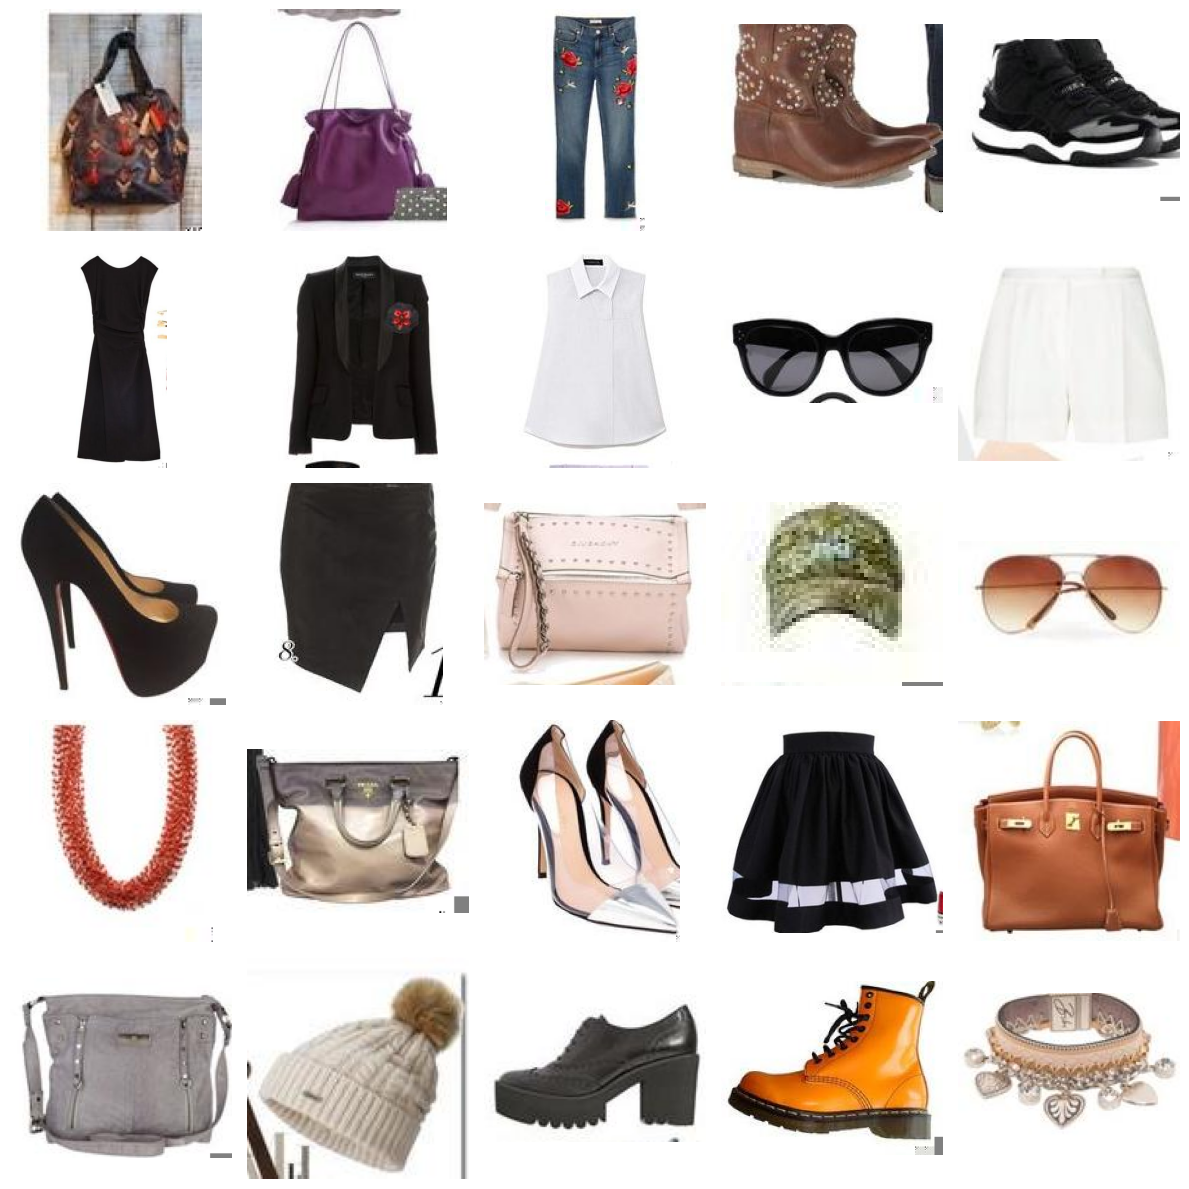

In [39]:
random_file_paths = random.sample(train_df['file_path'].tolist(), 25)
display_images_in_grid(random_file_paths)